In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

In [ ]:
# df1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet')
# df2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet')
# df3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet')
# df4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet')
# df5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet')
# df6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet')

In [32]:
# df = pd.concat([df1, df2, df3, df4, df5, df6])

In [37]:
df = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet')

In [38]:
def downcast_dtypes(df):
    # Downcast numerical columns to save memory
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64']).columns

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)

    return df

def preprocess_data(df):
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Downcast dtypes
    df = downcast_dtypes(df)
    
    # Feature Engineering
    df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
    df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
    df['pickup_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month
    
    # Encode categorical variables
    categorical_columns = ['pickup_day', 'RatecodeID', 'payment_type']
    df = pd.get_dummies(df, columns=categorical_columns)
    
    return df


In [39]:
df = preprocess_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float32       
 4   trip_distance          float32       
 5   store_and_fwd_flag     object        
 6   PULocationID           int32         
 7   DOLocationID           int32         
 8   fare_amount            float32       
 9   extra                  float32       
 10  mta_tax                float32       
 11  tip_amount             float32       
 12  tolls_amount           float32       
 13  improvement_surcharge  float32       
 14  total_amount           float32       
 15  congestion_surcharge   float32       
 16  Airport_fee            float32       
 17  pickup_hour            int32         
 18  pickup_month          

In [41]:
missing_values = df.isnull().sum()
missing_values

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count               0
trip_distance                 0
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
Airport_fee                   0
pickup_hour                   0
pickup_month                  0
pickup_day_Friday             0
pickup_day_Monday             0
pickup_day_Saturday           0
pickup_day_Sunday             0
pickup_day_Thursday           0
pickup_day_Tuesday            0
pickup_day_Wednesday          0
RatecodeID_1.0                0
RatecodeID_2.0                0
RatecodeID_3.0                0
RatecodeID_4.0                0
RatecodeID_5.0                0
Ratecode

In [42]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,...,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_0.0,payment_type_1.0,payment_type_2.0,payment_type_3.0,payment_type_4.0
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,N,186,79,17.700001,1.0,...,False,False,False,False,False,False,False,True,False,False
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,N,140,236,10.000000,3.5,...,False,False,False,False,False,False,True,False,False,False
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,N,236,79,23.299999,3.5,...,False,False,False,False,False,False,True,False,False,False
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,N,79,211,10.000000,3.5,...,False,False,False,False,False,False,True,False,False,False
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,N,211,148,7.900000,3.5,...,False,False,False,False,False,False,True,False,False,False


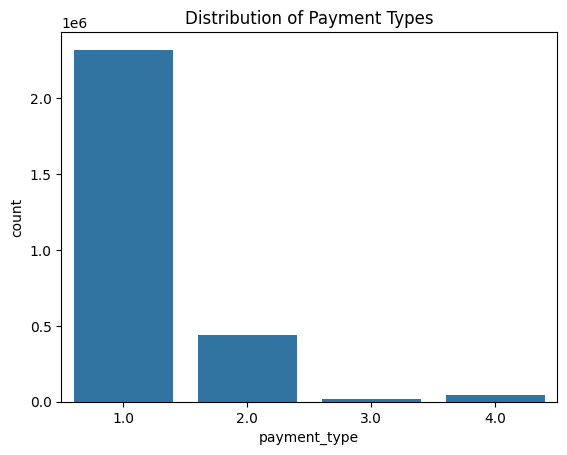

In [26]:
# Visualize distribution of payment types
sns.countplot(x='payment_type', data=df)
plt.title("Distribution of Payment Types")
plt.show()

In [ ]:
# Encoding categorical variables (if any) ------------------------- make repective code change
# categorical_columns = ['payment_type']  # Example: replace with actual categorical columns
# df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [11]:
# Feature scaling (if required)
scaler = StandardScaler()
numerical_columns = ['trip_distance', 'fare_amount', 'tip_amount']  # Example: replace with actual numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float32       
 4   trip_distance          float32       
 5   store_and_fwd_flag     object        
 6   PULocationID           int32         
 7   DOLocationID           int32         
 8   fare_amount            float32       
 9   extra                  float32       
 10  mta_tax                float32       
 11  tip_amount             float32       
 12  tolls_amount           float32       
 13  improvement_surcharge  float32       
 14  total_amount           float32       
 15  congestion_surcharge   float32       
 16  Airport_fee            float32       
 17  pickup_hour            int32         
 18  pickup_month          

In [ ]:
# # Drop rows with any missing values
# df = df.dropna()

# # Drop columns with missing values
# df = df.dropna(axis=1)

In [44]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,...,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_0.0,payment_type_1.0,payment_type_2.0,payment_type_3.0,payment_type_4.0
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,N,186,79,17.700001,1.00,...,False,False,False,False,False,False,False,True,False,False
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,N,140,236,10.000000,3.50,...,False,False,False,False,False,False,True,False,False,False
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,N,236,79,23.299999,3.50,...,False,False,False,False,False,False,True,False,False,False
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,N,79,211,10.000000,3.50,...,False,False,False,False,False,False,True,False,False,False
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,N,211,148,7.900000,3.50,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,1.0,3.18,None,107,263,15.770000,0.00,...,False,False,False,False,False,True,False,False,False,False
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,1.0,4.00,None,114,236,18.400000,1.00,...,False,False,False,False,False,True,False,False,False,False
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,1.0,3.33,None,211,25,19.969999,0.00,...,False,False,False,False,False,True,False,False,False,False
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,1.0,3.06,None,107,13,23.879999,0.00,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)


In [ ]:
# Display MI Scores
print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))


Mutual Information Scores:
tip_amount               0.377676
congestion_surcharge     0.278477
total_amount             0.270437
improvement_surcharge    0.269363
mta_tax                  0.252678
VendorID                 0.216795
passenger_count          0.213087
extra                    0.081692
fare_amount              0.057097
RatecodeID               0.039901
DOLocationID             0.023416
PULocationID             0.020792
trip_distance            0.015810
Airport_fee              0.013675
tolls_amount             0.009004
dtype: float64


In [16]:
# Split into features and target
X = df[['tip_amount', 'congestion_surcharge', 'total_amount', 'improvement_surcharge', 'mta_tax', 'VendorID', 'passenger_count', 'extra', 'fare_amount']]  # Replace 'payment_type' with your target column name
y = df['payment_type']

In [46]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [47]:
# for XGboost, the index should start from 0
if y.min() != 0:
    y = y - y.min()  # Reindex to start from 0

In [19]:
# K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = {model_name: {"accuracy": [], "f1_score": []} for model_name in models}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
        
        results[model_name]["accuracy"].append(acc)
        results[model_name]["f1_score"].append(f1)

# Display average metrics for each model
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"Average F1-Score: {np.mean(metrics['f1_score']):.4f}")

c:\Users\Dipika Bogati\Documents\Data Science\cs6010_fa2024_project_g06\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Dipika Bogati\Documents\Data Science\cs6010_fa2024_project_g06\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Dipika Bogati\Documents\Data Science\cs6010_fa2024_pro


Model: Logistic Regression
Average Accuracy: 0.9469
Average F1-Score: 0.9448

Model: Random Forest
Average Accuracy: 0.9515
Average F1-Score: 0.9505

Model: XGBoost
Average Accuracy: 0.9498
Average F1-Score: 0.9490

Model: Decision Tree
Average Accuracy: 0.9507
Average F1-Score: 0.9497


<Figure size 1600x1200 with 0 Axes>

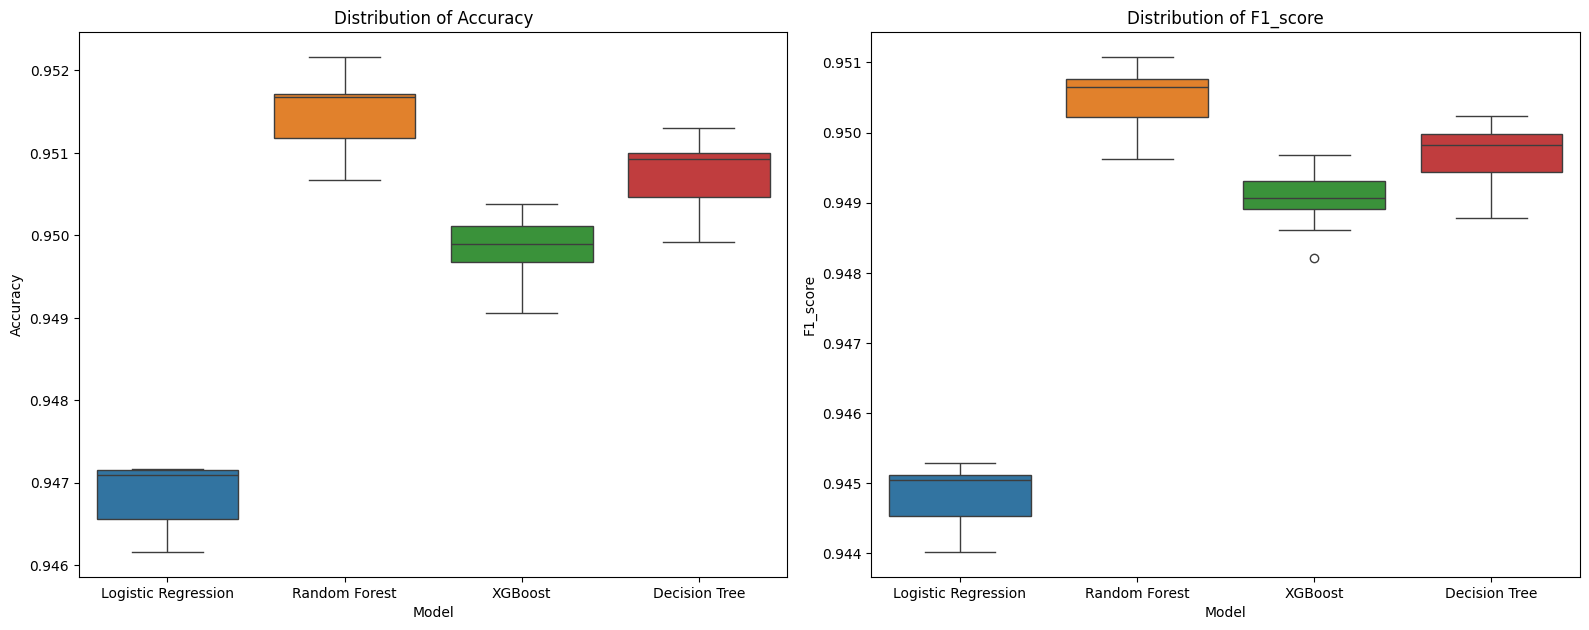

In [29]:
# Visualizing the distributions of metrics (accuracy, precision, f1 score) for each model
metrics_to_plot = ['accuracy', 'f1_score']

plt.figure(figsize=(16, 12))

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data={model_name: metrics[metric] for model_name, metrics in results.items()})
    plt.title(f'Distribution of {metric.capitalize()}')
    plt.xlabel('Model')
    plt.ylabel(metric.capitalize())

plt.tight_layout()
plt.show()